<a href="https://colab.research.google.com/github/ran4erep/Stable-Colab/blob/main/Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

↑ Желательно нажать Файл --> Сохранить копию на Диске

Это нужно чтобы все введённые вами данные сохранялись. Например токен для сайта CivitAI, чтобы не копировать и не вставлять его в соответсвующее поле каждый раз.

[Видео-инструкция](https://www.youtube.com/embed/VQ3YvX0-9wQ?si=19q0p3cpUpul8lVl)

[Ответы на часто задаваемые вопросы и разъяснения по поводу использования LoRA](https://www.youtube.com/embed/-ZI4TH8fjgM?si=QEGKbNAYzPee5RVE)

[Обновлённая инструкция по версии 1.4.2](https://youtu.be/klMvuBeYGIU?si=sJUFZkgy4ZxH0KJQ)

[Stable Colab 1.5.1: Использование моделей с сайта CivitAI](https://youtu.be/_YtwhJWud40?si=1iPy7uuStUNLa4L3)

In [1]:
# @title Установка Stable Diffusion и подключение Google Drive: { vertical-output: true, form-width: "10%", display-mode: "form" }
# @markdown Хотите исользовать Google Drive?
use_gdrive = False # @param {type:"boolean"}
# @markdown

import os
import re
import torch
import gc
import sys
import shutil
from google.colab import files
from PIL import Image
import io
import numpy as np
from datetime import date
from datetime import datetime
from IPython.display import clear_output
from IPython.display import display, update_display
import ipywidgets as widgets
import requests
from tqdm import tqdm
from urllib.parse import unquote

if use_gdrive:
  from google.colab import drive
  drive.mount('/content/gdrive')
  print("GDrive sucessfully mounted to /content/gdrive")
  # Создаём папку в Google Drive, если её нет
  if not os.path.exists("/content/gdrive/MyDrive/SDOutput"):
    os.makedirs("/content/gdrive/MyDrive/SDOutput", exist_ok=True)
    print("Успешно создана папка /content/gdrive/MyDrive/SDOutput")

!pip install transformers==4.39.3
!pip install peft==0.11.1
!pip install diffusers["torch"]==0.29.0
!pip install accelerate==0.29.3
!pip install compel==2.0.3
!pip install easygoogletranslate==0.0.4

from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image, AutoPipelineForInpainting
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
)
from diffusers.utils import make_image_grid, load_image
from compel import Compel, ReturnedEmbeddingsType
import transformers

from easygoogletranslate import EasyGoogleTranslate
translator = EasyGoogleTranslate()

used_models_array = [""]
previous_checkpoint = None
previous_lora_path = None
pipe = None
previous_mode = None
downloaded_model_name = None
downloaded_model_basename = None
downloaded_lora_name = None
downloaded_lora_basename = None
current_url = None
previous_url = None
lora_url = None
previous_lora_url = None
civitai_models = []
previous_clip_skip = 1

clear_output()
print("Установка завершена :)")

Установка завершена :)


In [2]:
# @title Подготовка Stable Diffusion: { vertical-output: true, form-width: "10%", display-mode: "form" }
# @markdown
# @markdown Модели для загрузки в скрипт:
# @markdown
# @markdown [CivitAI](https://civitai.com/models)
# @markdown
# @markdown [HuggingFace](https://huggingface.co/models?library=diffusers)

#!nvidia-smi

####################
# Список опробованных мною моделей:
# PicX_real:       GraydientPlatformAPI/picx-real
# Juggernaut:      digiplay/Juggernaut_final
# Juggernaut XL:   frankjoshua/juggernautXL_version6Rundiffusion
# RealVisXL 3.0:   SG161222/RealVisXL_V3.0_Turbo
# Base 1.5:        runwayml/stable-diffusion-v1-5
# Base SDXL:       stabilityai/stable-diffusion-xl-base-1.0
# Base SDXL Turbo: stabilityai/sdxl-turbo
####################


# @markdown ---
# @markdown Ваш токен с сайта CivitAI (опционально, для скачивания моделей с CivitAI, которые требуют регистрацию на сайте.
# @markdown
# @markdown Взять его можно в настройках вашего аккаунта CivitAI, в блоке API Keys):
civitai_token = "" # @param {type:"string"}
# @markdown Модель для загрузки:
current_checkpoint = "GraydientPlatformAPI/picx-real" # @param ["runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-xl-base-1.0", "runwayml/stable-diffusion-inpainting", "stabilityai/sdxl-turbo", "digiplay/Juggernaut_final", "GraydientPlatformAPI/picx-real", "frankjoshua/juggernautXL_version6Rundiffusion", "SG161222/RealVisXL_V3.0_Turbo", "SG161222/Realistic_Vision_V6.0_B1_noVAE", "stablediffusionapi/lob-realvisxl-v20", "kandinsky-community/kandinsky-2-2-decoder-inpaint", "fluently/Fluently-v3-inpainting"] {allow-input: true}
# @markdown Использовать safetensors?
use_safetensors = True # @param ["True", "False", "None"] {type:"raw"}

# @markdown ---
# @markdown Использовать LoRA?
use_lora = False # @param {type:"boolean"}
# @markdown Текущая LoRA:
# @markdown ---
# @markdown Для скачивания с HuggingFace:
lora_path = "" # @param ["nerijs/pixel-art-xl", "ntc-ai/SDXL-LoRA-slider.cinematic-lighting"] {allow-input: true}
# @markdown Имя файла LoRA:
weight_name = "" # @param ["pixel-art-xl.safetensors", "cinematic lighting.safetensors"] {allow-input: true}
# @markdown ---
# @markdown Ссылка на LoRA для скачивания с сайта CivitAI:
lora_url = "" # @param {type:"string"}
# @markdown ---
current_device = "cuda"
# @markdown Пропуск CLIP
# @markdown (1 означает что используются все слои, это является значением по умолчанию):
clip_skip = 1 # @param {type:"slider", min:1, max:12, step:1}
## @markdown Вариант:
#current_variant = "fp16" # @param ["", "fp16", "ema"]

display_handle = display(None, display_id=True)

def load_civit_model(url):
  global current_checkpoint, previous_checkpoint, downloaded_model_name, downloaded_model_basename, previous_url, current_url, civitai_models
  for element in civitai_models:
    if current_checkpoint in element[0]:
      current_checkpoint = element[1]
      return

  if current_url != previous_url:
    if civitai_token:
      url = url + "&token=" + civitai_token
    response = requests.get(url, stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 100000
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

    if 'content-disposition' in response.headers:
      content_disposition = response.headers['content-disposition']
      filename_index = content_disposition.find('filename=')
      if filename_index != -1:
        filename = content_disposition[filename_index + len('filename='):]
        filename = unquote(filename)
        filename = filename.strip('"')
        downloaded_model_name = filename
    if not downloaded_model_name:
      downloaded_model_name = os.path.basename(url)

    downloaded_model_basename, _ = os.path.splitext(downloaded_model_name)
    with open(downloaded_model_name, 'wb') as file:
      for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
      print("Ошибка при скачивании модели :(")

    print("\nМодель " + downloaded_model_basename + " успешно загружена :) ")
    print("Подождите, идёт конвертация модели...\n")

    from pkg_resources import get_distribution
    diffusers_version = get_distribution('diffusers').version
    lib_url = "https://raw.githubusercontent.com/huggingface/diffusers/v" + diffusers_version + "/scripts/convert_original_stable_diffusion_to_diffusers.py"
    !wget "$lib_url"

    !python convert_original_stable_diffusion_to_diffusers.py --checkpoint_path "$downloaded_model_name" --dump_path "$downloaded_model_basename/" --from_safetensors
    previous_url = current_checkpoint
    current_checkpoint = downloaded_model_basename
    civitai_models.append((url, downloaded_model_basename))
    os.remove(downloaded_model_name)
    os.remove("convert_original_stable_diffusion_to_diffusers.py")
    clear_output()
    print("Модель " + downloaded_model_basename + " успешно сконвертирована и готова к работе :)")

repo_regexp = r'[^\/\s]+\s*\/\s*[^\/\s]+'
link_regexp = r'^https?://\S+$'

if re.match(repo_regexp, current_checkpoint):
  current_checkpoint = current_checkpoint
elif re.match(link_regexp, current_checkpoint):
  current_url = current_checkpoint
  load_civit_model(current_checkpoint)
else:
  print("Не удалось найти модель по вашей ссылке. :( Укажите ссылку на репозиторий HuggingFace вида \"author/model_name\" или прямую ссылку на файл .safetensors с сайта CivitAI")

def flush():
  del(pipe)
  gc.collect()
  torch.cuda.empty_cache()


if 'pipe' in locals() and use_lora:
  pipe.unload_lora_weights()

def run_chkpt(current_checkpoint, lora_path, use_lora, mode):
    global previous_checkpoint, previous_lora_path, previous_mode, lora_url, previous_lora_url, downloaded_lora_basename, downloaded_lora_name, pipe, clip_skip, previous_clip_skip
    if current_checkpoint != previous_checkpoint or mode != previous_mode or previous_clip_skip != clip_skip:
        used_models_array.append(current_checkpoint)
        print("Устанавливаю модель...")
        if clip_skip > 1:
          text_encoder = transformers.CLIPTextModel.from_pretrained(current_checkpoint, subfolder = "text_encoder", num_hidden_layers = 12 - (clip_skip - 1), torch_dtype = torch.float16)
        if mode == "txt2img":
          if clip_skip > 1:
            pipe = AutoPipelineForText2Image.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors, text_encoder = text_encoder)
          else:
            pipe = AutoPipelineForText2Image.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors)
        if mode == "img2img":
          if clip_skip > 1:
            pipe = AutoPipelineForImage2Image.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors, text_encoder = text_encoder)
          else:
            pipe = AutoPipelineForImage2Image.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors)
        if mode == "inpainting":
          if clip_skip > 1:
            pipe = AutoPipelineForInpainting.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors, text_encoder = text_encoder)
          else:
            pipe = AutoPipelineForInpainting.from_pretrained(current_checkpoint, torch_dtype=torch.float16, use_safetensors=use_safetensors)
        pipe = pipe.to(current_device)
        pipe.safety_checker = None
        if current_scheduler == "ddpm":
          pipe.scheduler = ddpm.from_config(pipe.scheduler.config)
        if current_scheduler == "ddim":
          pipe.scheduler = ddim.from_config(pipe.scheduler.config)
        if current_scheduler == "pndm":
          pipe.scheduler = pndm.from_config(pipe.scheduler.config)
        if current_scheduler == "lms":
          pipe.scheduler = lms.from_config(pipe.scheduler.config)
        if current_scheduler == "euler":
          pipe.scheduler = euler.from_config(pipe.scheduler.config)
        if current_scheduler == "euler_anc":
          pipe.scheduler = euler_anc.from_config(pipe.scheduler.config)
        if current_scheduler == "dpm":
          pipe.scheduler = dpm.from_config(pipe.scheduler.config)
        print("Всё готово к работе :)")
        clear_output()
        previous_mode = mode
        previous_checkpoint = current_checkpoint
        previous_clip_skip = clip_skip
    if use_lora:
      if lora_path != previous_lora_path and lora_url == "":
        if pipe:
          pipe.unload_lora_weights()
        print("Устанавливаю LoRA модель...")
        pipe.load_lora_weights(lora_path, weight_name=weight_name)
        print("Всё готово к работе :)")
        previous_lora_path = lora_path
      if lora_url != previous_lora_url and lora_path == "" and weight_name == "":
        if pipe:
          pipe.unload_lora_weights()
        response = requests.get(lora_url, stream=True)
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 100000
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        if 'content-disposition' in response.headers:
          content_disposition = response.headers['content-disposition']
          filename_index = content_disposition.find('filename=')
          if filename_index != -1:
            filename = content_disposition[filename_index + len('filename='):]
            filename = unquote(filename)
            filename = filename.strip('"')
            downloaded_lora_name = filename
        if not downloaded_lora_name:
          downloaded_lora_name = os.path.basename(lora_url)

        downloaded_lora_basename, _ = os.path.splitext(downloaded_lora_name)
        with open(downloaded_lora_name, 'wb') as file:
          for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
        progress_bar.close()
        if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
          print("Ошибка при скачивании модели :(")
        pipe.load_lora_weights(downloaded_lora_name)
        previous_lora_url = lora_url
        print("Всё готово к работе :)")


# print("\nСписок использованных моделей в течении сессии:")
# model_fields = []
# for i, model_name in enumerate(used_models_array, start=1):
#     if model_name:
#       model_field = widgets.Text(
#           value=model_name,
#           description=f'Модель {i-1}:',
#           disabled=False,
#           layout=widgets.Layout(width="auto")
#       )
#       model_fields.append(model_field)

# display(widgets.VBox(model_fields))

# if len(used_models_array) == 1:
#   print("Пока что список моделей пуст :(")

None

In [3]:
# @title Настройка параметров генерации: { form-width: "10%", display-mode: "form" }
# Здесь указываем переменные для пайплайна Stable Diffusion
# Дефолтный промпт для лучшего качества: (8k, ultra realistic, highly detailed, cinematic lighting)

# @markdown Язык промпта и негативного промпта:
language = "English" # @param ["English", "Русский", "Автоопределение"]
# @markdown Промпт:
prompt = "cute cat" # @param {type:"string"}
# @markdown Негативный промпт:
negs = "" # @param {type:"string"}
if language == "Русский":
  prompt = translator.translate(prompt, source_language='ru', target_language='en')
  negs = translator.translate(negs, source_language='ru', target_language='en')
elif language == "Автоопределение":
  prompt = translator.translate(prompt, target_language='en')
  negs = translator.translate(negs, target_language='en')
else:
  prompt = prompt
  negs = negs

# @markdown Стиль генерируемого изображения:
styles = "Без стиля" # @param ["Без стиля", "ran4erep's style", "3D модель", "Аналоговая плёнка", "Аниме", "Кинематографичный", "Комикс", "Пластилин", "Цифровой арт", "Фентези", "Изометрический", "Набросок", "Лоу-поли", "Неонпанк", "Оригами", "Фотография", "Пиксель-арт", "Текстура", "Абстракция", "Абстрактный экспрессионизм", "Гиперреализм", "Поп-арт", "Ренесанс", "Стимпанк", "Сюрреализм", "Футуризм", "Синтвейв-футуризм", "Ретро-футуризм", "Сай-фай", "Вапорвейв-футуризм", "Антиутопический", "Готический", "Гранж", "Хоррор", "Лавкрафтовский", "Жуткий", "Минимализм", "Нуар", "Длинная выдержка", "Tilt-Shift", "Фото со смартфона"]
# @markdown ---

def latents_to_rgb(latents):
    weights = (
        (60, -60, 25, -70),
        (60,  -5, 15, -50),
        (60,  10, -5, -35)
    )

    weights_tensor = torch.t(torch.tensor(weights, dtype=latents.dtype).to(latents.device))
    biases_tensor = torch.tensor((150, 140, 130), dtype=latents.dtype).to(latents.device)
    rgb_tensor = torch.einsum("...lxy,lr -> ...rxy", latents, weights_tensor) + biases_tensor.unsqueeze(-1).unsqueeze(-1)
    image_array = rgb_tensor.clamp(0, 255)[0].byte().cpu().numpy()
    image_array = image_array.transpose(1, 2, 0)  # Change the order of dimensions

    return Image.fromarray(image_array)

def decode_tensors(pipe, step, timestep, callback_kwargs):
  if step % 5 == 0:
    latents = callback_kwargs["latents"]

    image = latents_to_rgb(latents)
    image_resized = image.resize((412, 412), Image.NEAREST)
    update_display(image_resized, display_id=display_handle.display_id)

  return callback_kwargs

if styles != "Без стиля":
  if styles == "ran4erep's style":
    prompt = prompt + ", 8k, ultra realistic, highly detailed"
    negs = negs + ", canvas frame, cartoon, 3d, disfigured, bad art, deformed, extra limbs, close up, b&w, wierd colors, blurry, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, out of frame, ugly, extra limbs, bad anatomy, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, mutated hands, fused fingers, too many fingers, long neck, Photoshop, video game, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, 3d render"
  if styles == "3D модель":
    prompt = "professional 3d model {" + prompt + "} . octane render, highly detailed, volumetric, dramatic lighting"
    negs   = negs + ", ugly, deformed, noisy, low poly, blurry, painting"
  if styles == "Аналоговая плёнка":
    prompt = "analog film photo {" + prompt + "} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage"
    negs   = negs + ", painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured"
  if styles == "Аниме":
    prompt = "anime artwork {" + prompt + "} . anime style, key visual, vibrant, studio anime, highly detailed"
    negs   = negs + ", photo, deformed, black and white, realism, disfigured, low contrast"
  if styles == "Кинематографичный":
    prompt = "cinematic film still {" + prompt + "} . shallow depth of field, vignette, highly detailed, high budget, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy"
    negs   = negs + ", anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured"
  if styles == "Комикс":
    prompt = "comic {" + prompt + "} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed"
    negs   = negs + ", photograph, deformed, glitch, noisy, realistic, stock photo"
  if styles == "Пластилин":
    prompt = "play-doh style {" + prompt + "} . sculpture, clay art, centered composition, Claymation"
    negs   = negs + ", sloppy, messy, grainy, highly detailed, ultra textured, photo"
  if styles == "Цифровой арт":
    prompt = "concept art {" + prompt + "} . digital artwork, illustrative, painterly, matte painting, highly detailed"
    negs   = negs + ", photo, photorealistic, realism, ugly"
  if styles == "Фентези":
    prompt = "ethereal fantasy concept art of {" + prompt + "} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy"
    negs   = negs + ", photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white"
  if styles == "Изометрический":
    prompt = "isometric style {" + prompt + "} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate"
    negs   = negs + ", deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic"
  if styles == "Набросок":
    prompt = "line art drawing {" + prompt + "} . professional, sleek, modern, minimalist, graphic, line art, vector graphics"
    negs   = negs + ", anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic"
  if styles == "Лоу-поли":
    prompt = "low-poly style {" + prompt + "} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition"
    negs   = negs + ", noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo"
  if styles == "Неонпанк":
    prompt = "neonpunk style {" + prompt + "} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional"
    negs   = negs + ", painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured"
  if styles == "Оригами":
    prompt = "origami style {" + prompt + "} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition"
    negs   = negs + ", noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo"
  if styles == "Фотография":
    prompt = "cinematic photo {" + prompt + "} . 35mm photograph, film, bokeh, professional, 4k, highly detailed"
    negs   = negs + ", drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly"
  if styles == "Пиксель-арт":
    prompt = "pixel-art {" + prompt + "} . low-res, blocky, pixel art style, 8-bit graphics"
    negs   = negs + ", sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic"
  if styles == "Текстура":
    prompt = "texture {" + prompt + "} top down close-up"
    negs   = negs + ", ugly, deformed, noisy, blurry"
  if styles == "Абстракция":
    prompt = "abstract style {" + prompt + "} . non-representational, colors and shapes, expression of feelings, imaginative, highly detailed"
    negs   = negs + ", realistic, photographic, figurative, concrete"
  if styles == "Абстрактный экспрессионизм":
    prompt = "abstract expressionist painting {" + prompt + "} . energetic brushwork, bold colors, abstract forms, expressive, emotional"
    negs   = negs + ", realistic, photorealistic, low contrast, plain, simple, monochrome"
  if styles == "Гиперреализм":
    prompt = "hyperrealistic art {" + prompt + "} . extremely high-resolution details, photographic, realism pushed to extreme, fine texture, incredibly lifelike"
    negs   = negs + ", simplified, abstract, unrealistic, impressionistic, low resolution"
  if styles == "Поп-арт":
    prompt = "pop Art style {" + prompt + "} . bright colors, bold outlines, popular culture themes, ironic or kitsch"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, minimalist"
  if styles == "Ренесанс":
    prompt = "renaissance style {" + prompt + "} . realistic, perspective, light and shadow, religious or mythological themes, highly detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, modernist, minimalist, abstract"
  if styles == "Стимпанк":
    prompt = "steampunk style {" + prompt + "} . antique, mechanical, brass and copper tones, gears, intricate, detailed"
    negs   = negs + ", deformed, glitch, noisy, low contrast, anime, photorealistic"
  if styles == "Сюрреализм":
    prompt = "surrealist art {" + prompt + "} . dreamlike, mysterious, provocative, symbolic, intricate, detailed"
    negs   = negs + ", anime, photorealistic, realistic, deformed, glitch, noisy, low contrast"
  if styles == "Футуризм":
    prompt = "futuristic style {" + prompt + "} . sleek, modern, ultramodern, high tech, detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, vintage, antique"
  if styles == "Синтвейв-футуризм":
    prompt = "retro cyberpunk {" + prompt + "} . 80’s inspired, synthwave, neon, vibrant, detailed, retro futurism"
    negs   = negs + ", modern, desaturated, black and white, realism, low contrast"
  if styles == "Ретро-футуризм":
    prompt = "retro-futuristic {" + prompt + "} . vintage sci-fi, 50s and 60s style, atomic age, vibrant, highly detailed"
    negs   = negs + ", contemporary, realistic, rustic, primitive"
  if styles == "Сай-фай":
    prompt = "sci-fi style {" + prompt + "} . futuristic, technological, alien worlds, space themes, advanced civilizations"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, historical, medieval"
  if styles == "Вапорвейв-футуризм":
    prompt = "vaporwave style {" + prompt + "} . retro aesthetic, cyberpunk, vibrant, neon colors, vintage 80s and 90s style, highly detailed"
    negs   = negs + ", monochrome, muted colors, realism, rustic, minimalist, dark"
  if styles == "Антиутопический":
    prompt = "dystopian style {" + prompt + "} . bleak, post-apocalyptic, somber, dramatic, highly detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, cheerful, optimistic, vibrant, colorful"
  if styles == "Готический":
    prompt = "gothic style {" + prompt + "} . dark, mysterious, haunting, dramatic, ornate, detailed"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, cheerful, optimistic"
  if styles == "Гранж":
    prompt = "grunge style {" + prompt + "} . textured, distressed, vintage, edgy, punk rock vibe, dirty, noisy"
    negs   = negs + ", smooth, clean, minimalist, sleek, modern, photorealistic"
  if styles == "Хоррор":
    prompt = "horror-themed {" + prompt + "} . eerie, unsettling, dark, spooky, suspenseful, grim, highly detailed"
    negs   = negs + ", cheerful, bright, vibrant, light-hearted, cute"
  if styles == "Лавкрафтовский":
    prompt = "lovecraftian horror {" + prompt + "} . eldritch, cosmic horror, unknown, mysterious, surreal, highly detailed"
    negs   = negs + ", light-hearted, mundane, familiar, simplistic, realistic"
  if styles == "Жуткий":
    prompt = "macabre style {" + prompt + "} . dark, gothic, grim, haunting, highly detailed"
    negs   = negs + ", bright, cheerful, light-hearted, cartoonish, cute"
  if styles == "Минимализм":
    prompt = "minimalist style {" + prompt + "} . simple, clean, uncluttered, modern, elegant"
    negs   = negs + ", ornate, complicated, highly detailed, cluttered, disordered, messy, noisy"
  if styles == "Нуар":
    prompt = "film noir style {" + prompt + "} . monochrome, high contrast, dramatic shadows, 1940s style, mysterious, cinematic"
    negs   = negs + ", ugly, deformed, noisy, blurry, low contrast, realism, photorealistic, vibrant, colorful"
  if styles == "Длинная выдержка":
    prompt = "long exposure photo of {" + prompt + "} . Blurred motion, streaks of light, surreal, dreamy, ghosting effect, highly detailed"
    negs   = negs + ", static, noisy, deformed, shaky, abrupt, flat, low contrast"
  if styles == "Tilt-Shift":
    prompt = "tilt-shift photo of {" + prompt + "} . selective focus, miniature effect, blurred background, highly detailed, vibrant, perspective control"
    negs   = negs + ", blurry, noisy, deformed, flat, low contrast, unrealistic, oversaturated, underexposed"
  if styles == "Фото со смартфона":
    prompt = "iphone photo {" + prompt + "} . large depth of field, deep depth of field, highly detailed"
    negs   = negs + ", drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly, shallow depth of field, bokeh"
# @markdown Для какой версии Stable Diffusion вы загрузили модель? (Это важно для работоспособности веса токенов, иначе будет ошибка)
sd_type = "Stable Diffusion 1.5/2.0" # @param ["Stable Diffusion 1.5/2.0", "Stable Diffusion XL (Turbo)", "Отключить веса токенов (для совместимости)"]
# @markdown Вес для SD 1.5 записывается как + или - после слова внутри токена: "cat playing with ball+++++", "cat+ playing with ball"
# @markdown
# @markdown Вес для SDXL записывается как дробное число после скобок, внутри которых есть слово или даже целый токен: "cat (playing with ball)1.5"
# @markdown
# @markdown ---
# @markdown Ширина:
width = 512 # @param {type:"number"}
# @markdown Высота:
height = 512 # @param {type:"number"}
# @markdown Количество изображений:
images_count = 1 # @param {type:"slider", min:1, max:10, step:1}
# @markdown Шаги:
steps = 25 # @param {type:"number"}
# @markdown Шкала инструкции:
gscale = 7.5 # @param {type:"number"}
# @markdown Текущий планировщик:
current_scheduler = "euler_anc" # @param ["ddpm", "ddim", "pndm", "lms", "euler_anc", "euler", "dpm"] {type:"string"}

if pipe in globals() or pipe is not None:
  if current_scheduler == "ddpm":
    pipe.scheduler = ddpm.from_config(pipe.scheduler.config)
  if current_scheduler == "ddim":
    pipe.scheduler = ddim.from_config(pipe.scheduler.config)
  if current_scheduler == "pndm":
    pipe.scheduler = pndm.from_config(pipe.scheduler.config)
  if current_scheduler == "lms":
    pipe.scheduler = lms.from_config(pipe.scheduler.config)
  if current_scheduler == "euler":
    pipe.scheduler = euler.from_config(pipe.scheduler.config)
  if current_scheduler == "euler_anc":
    pipe.scheduler = euler_anc.from_config(pipe.scheduler.config)
  if current_scheduler == "dpm":
    pipe.scheduler = dpm.from_config(pipe.scheduler.config)

# @markdown Использовать случайный seed?
randomness = True # @param {type:"boolean"}
# @markdown Seed:
seed = 1171722174033674 # @param {type:"integer"}

### Работа Stable Diffusion
Не запускайте этот блок кода целиком. Разверните его и вы увидите различные режимы работы Stable Diffusion. Запустите нужный вам режим.

######################################################################
# Текущая модель Stable Diffusion: GraydientPlatformAPI/picx-real
# Текущий стиль: Без стиля
# Промпт: cute cat
# Негативный промпт: 
# Разрешение: 512x512
# Количество генерируемых изображений: 1
# Seed этой генерации: 8359039692288905
######################################################################


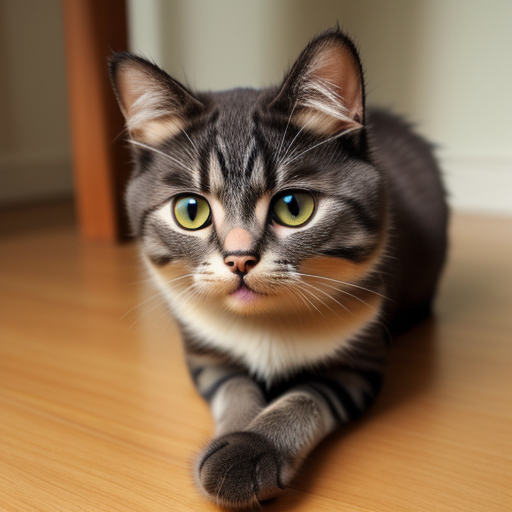

In [4]:
# @title Text2Image (Генерация изображения из текста): { form-width: "10%", display-mode: "form" }
# @markdown
# @markdown <-- Начать генерацию
# Генерация картинки
# @markdown
# @markdown Показывать диффузию в реальном времени?
show_diffusion = True # @param {type:"boolean"}

ddpm = DDPMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
ddim = DDIMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
pndm = PNDMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
lms = LMSDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler = EulerDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
dpm = DPMSolverMultistepScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")

run_chkpt(current_checkpoint, lora_path, use_lora, "txt2img")

if sd_type == "Stable Diffusion 1.5/2.0":
  compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
  prompt_embeds = compel_proc(prompt)

if sd_type == "Stable Diffusion XL (Turbo)":
  compel = Compel(
    tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
    text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    requires_pooled=[False, True]
  )
  conditioning, pooled = compel(prompt)

#####################################################################
# Информация о текущей генерации
prompt_display = '\n'.join([prompt[i:i+60] for i in range(0, len(prompt), 60)])
negs_display = '\n'.join([negs[i:i+60] for i in range(0, len(negs), 60)])

output = [
    "# Текущая модель Stable Diffusion: " + current_checkpoint,
]
if use_lora:
    if lora_url == "" and lora_path and weight_name:
      output.append("# Текущая модель LoRA: " + lora_path)
    elif lora_url and lora_path == "" and weight_name == "":
      output.append("# Текущая модель LoRA: " + downloaded_lora_basename)
output.extend([
    "# Текущий стиль: " + styles,
    "# Промпт: " + prompt_display,
    "# Негативный промпт: " + negs_display,
    "# Разрешение: " + str(width) + "x" + str(height),
    "# Количество генерируемых изображений: " + str(images_count)
])
#max_length_string = max(len(s.replace('\n', '')) for s in output)
max_length_string = 70

print("#" * max_length_string )
for item in output:
  print(item)

######################################################################
if not randomness:
  generator = torch.Generator(current_device).manual_seed(seed)
  print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * max_length_string) )
elif randomness:
  current_seed = torch.Generator(current_device).seed()
  generator = torch.Generator(current_device).manual_seed(current_seed)
  print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * max_length_string ))


#result = pipe(prompt=prompt, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

if sd_type == "Stable Diffusion 1.5/2.0":
  if show_diffusion:
    torch.cuda.empty_cache()
    result = pipe(prompt_embeds=prompt_embeds, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)
  else:
    torch.cuda.empty_cache()
    result = pipe(prompt_embeds=prompt_embeds, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

if sd_type == "Stable Diffusion XL (Turbo)":
  if show_diffusion:
    torch.cuda.empty_cache()
    result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)
  else:
    torch.cuda.empty_cache()
    result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

if sd_type == "Отключить веса токенов (для совместимости)":
  if show_diffusion:
    torch.cuda.empty_cache()
    result = pipe(prompt=prompt, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)
  else:
    torch.cuda.empty_cache()
    result = pipe(prompt=prompt, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count)

# Вывод и сохрарнение результата

if use_gdrive:
  today = str(date.today())
  if not os.path.exists("/content/gdrive/MyDrive/SDOutput/" + today):
    os.makedirs("/content/gdrive/MyDrive/SDOutput/" + today, exist_ok=True)
  for i in range(images_count):
    time = datetime.now()
    time = str(time.strftime("%H-%M-%S"))
    file_name = time + "_" + "seed_" + str(current_seed) + "_image" + str(i) +".png"
    file_name = "/content/gdrive/MyDrive/SDOutput/" + today + "/" + file_name
    images = make_image_grid(result.images, rows=1, cols=images_count)
    result.images[i].save(file_name)
    print("Сохранено: " + file_name)

clear_output()
#update_display(result, display_id=display_handle.display_id)
print("#" * max_length_string )
print("# Текущая модель Stable Diffusion: " + current_checkpoint)
if use_lora:
  if lora_url == "" and lora_path and weight_name:
    output.append("# Текущая модель LoRA: " + lora_path)
  elif lora_url and lora_path == "" and weight_name == "":
    output.append("# Текущая модель LoRA: " + downloaded_lora_basename)
print("# Текущий стиль: " + styles)
print("# Промпт: " + prompt_display)
print("# Негативный промпт: " + negs_display)
print("# Разрешение: " + str(width) + "x" + str(height))
print("# Количество генерируемых изображений: " + str(images_count))
if not randomness:
  print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * max_length_string ))
elif randomness:
  print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * max_length_string ))
make_image_grid(result.images, rows=1, cols=images_count)

In [ ]:
# @title Загрузка изображения для модуля Image2Image
# @markdown Ширина и высота вашего изображения должны делиться на 8 без остатка, иначе будет ошибка.
print("Выберите исходное изображение: ")
init_image = files.upload()
image_key = list(init_image.keys())[0]
image_data = init_image[image_key]
img = Image.open(io.BytesIO(image_data))
img_width, img_height = img.size
clear_output()
new_size = (128, 128)
img_preview = img.resize(new_size)
print("Изображение успешно загружено :)")
display(img_preview)

In [ ]:
# @title Image2Image (Генерация изображения из другого изображения): { form-width: "10%", display-mode: "form" }
# @markdown <-- Начать генерацию

# @markdown ---
# @markdown Сила:

# @markdown Чем ниже значене, тем ближе генерация будет к изображению, которое вы загрузили. Чем больше значение, тем сильнее нейросеть будет креативничать.

img2img_strength = 0.3 # @param {type:"slider", min:0.1, max:1.0, step:0.1}

# @markdown Силу нужно комбинировать с шагами. Итоговое количество шагов для генерации шума рассчитывается по формуле (Шаги * Сила).

# @markdown Шаги:
steps = 25 # @param {type:"number"}
# @markdown ---
# @markdown Показывать диффузию в реальном времени?
show_diffusion = True # @param {type:"boolean"}
# @markdown ---

ddpm = DDPMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
ddim = DDIMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
pndm = PNDMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
lms = LMSDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler = EulerDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
dpm = DPMSolverMultistepScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")

run_chkpt(current_checkpoint, lora_path, use_lora, "img2img")


if init_image:

  if sd_type == "Stable Diffusion 1.5/2.0":
    compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
    prompt_embeds = compel_proc(prompt)

  if sd_type == "Stable Diffusion XL (Turbo)":
    compel = Compel(
      tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
      text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
      returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
      requires_pooled=[False, True]
    )
    conditioning, pooled = compel(prompt)
  prompt_display = '\n'.join([prompt[i:i+60] for i in range(0, len(prompt), 60)])
  negs_display = '\n'.join([negs[i:i+60] for i in range(0, len(negs), 60)])
  output = [
      "# Текущая модель Stable Diffusion: " + current_checkpoint,
  ]
  if lora_url == "" and lora_path and weight_name:
    output.append("# Текущая модель LoRA: " + lora_path)
  elif lora_url and lora_path == "" and weight_name == "":
    output.append("# Текущая модель LoRA: " + downloaded_lora_basename)
  output.extend([
      "# Текущий стиль: " + styles,
      "# Промпт: " + prompt_display,
      "# Негативный промпт: " + negs_display,
      "# Разрешение: " + str(img_width) + "x" + str(img_height),
      "# Сила: " + str(img2img_strength)
  ])
  max_length_string = 70

  print("#" * max_length_string )
  for item in output:
    print(item)

  if not randomness:
    generator = torch.Generator(current_device).manual_seed(seed)
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * max_length_string) )
  elif randomness:
    current_seed = torch.Generator(current_device).seed()
    generator = torch.Generator(current_device).manual_seed(current_seed)
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * max_length_string ))

  if sd_type == "Stable Diffusion 1.5/2.0":
    if show_diffusion:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=prompt_embeds, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=img, strength = img2img_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images
    else:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=prompt_embeds, image=img, strength = img2img_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images

  if sd_type == "Stable Diffusion XL (Turbo)":
    if show_diffusion:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=img, strength = img2img_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images
    else:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, image=img, strength = img2img_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images

  if sd_type == "Отключить веса токенов (для совместимости)":
    if show_diffusion:
      torch.cuda.empty_cache()
      result = pipe(prompt=prompt, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=img, strength = img2img_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images
    else:
      torch.cuda.empty_cache()
      result = pipe(prompt=prompt, image=img, strength = img2img_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images

  result.insert(0, img)

  clear_output()
  print("#" * max_length_string )
  print("# Текущая модель Stable Diffusion: " + current_checkpoint)
  if use_lora:
    if lora_url == "" and lora_path and weight_name:
      output.append("# Текущая модель LoRA: " + lora_path)
    elif lora_url and lora_path == "" and weight_name == "":
      output.append("# Текущая модель LoRA: " + downloaded_lora_basename)
  print("# Текущий стиль: " + styles)
  print("# Промпт: " + prompt_display)
  print("# Негативный промпт: " + negs_display)
  print("# Разрешение: " + str(img_width) + "x" + str(img_height))
  print("# Сила: " + str(img2img_strength))
  if not randomness:
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * max_length_string ))
  elif randomness:
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * max_length_string ))

  if use_gdrive:
    today = str(date.today())
    if not os.path.exists("/content/gdrive/MyDrive/SDOutput/" + today):
      os.makedirs("/content/gdrive/MyDrive/SDOutput/" + today, exist_ok=True)
    for i in range(images_count+1):
      if i > 0:
        time = datetime.now()
        time = str(time.strftime("%H-%M-%S"))
        file_name = time + "_" + "seed_" + str(current_seed) + "_image_" + str(i) + "_img2imged.png"
        file_name = "/content/gdrive/MyDrive/SDOutput/" + today + "/" + file_name
        result[i].save(file_name)
        print("Сохранено: " + file_name)
      else:
        pass

  display( make_image_grid(result, rows=1, cols=len(result) ) )
else:
  print("Отсутствует изображение для генерации :(")

In [ ]:
# @title Загрузка изображений для модуля Inpainting
# @markdown Ширина и высота ваших изображений должны делиться на 8 без остатка, иначе будет ошибка.
print("Выберите исходное изображение: ")
inpaint_image = files.upload()
print("Выберите изображение маски: ")
inpaint_mask =  files.upload()

inpaint_image_key = list(inpaint_image.keys())[0]
inpaint_mask_image_key = list(inpaint_mask.keys())[0]
inpaint_image_data = inpaint_image[inpaint_image_key]
inpaint_mask_image_data = inpaint_mask[inpaint_mask_image_key]
inpaint_image = Image.open(io.BytesIO(inpaint_image_data)).convert('RGB')
inpaint_mask_image = Image.open(io.BytesIO(inpaint_mask_image_data)).convert('RGB')
inpaint_image_width, inpaint_image_height = inpaint_image.size
inpaint_image_mask_width, inpaint_image_mask_height = inpaint_mask_image.size
clear_output()
new_size = (128, 128)
inpaint_image_preview = inpaint_image.resize(new_size)
inpaint_mask_image_preview = inpaint_mask_image.resize(new_size)
print("Изображения успешно загружены :)")
display( make_image_grid([inpaint_image_preview, inpaint_mask_image_preview], rows=1, cols=2 ) )

In [ ]:
# @title Inpainting (Генерация изображения из другого изображения с использованием маски): { form-width: "10%", display-mode: "form" }
# @markdown <-- Начать генерацию

# @markdown ---
# @markdown Сила:

# @markdown Чем ниже значене, тем ближе генерация будет к изображению, которое вы загрузили. Чем больше значение, тем сильнее нейросеть будет креативничать.

inpaint_strength = 0.4 # @param {type:"slider", min:0.1, max:1.0, step:0.1}

# @markdown Силу нужно комбинировать с шагами. Итоговое количество шагов для генерации шума рассчитывается по формуле (Шаги * Сила).

# @markdown Шаги:
steps = 25 # @param {type:"number"}
# @markdown ---
# @markdown Показывать диффузию в реальном времени?
show_diffusion = True # @param {type:"boolean"}
# @markdown ---
# @markdown При рисовании маски помните, что чёрные области игнорируются нейросетью, а белые - нет. Размытия белых областей в масках тоже поддерживаются.

ddpm = DDPMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
ddim = DDIMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
pndm = PNDMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
lms = LMSDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler = EulerDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
dpm = DPMSolverMultistepScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")

run_chkpt(current_checkpoint, lora_path, use_lora, "inpainting")

if inpaint_image and inpaint_mask:

  if sd_type == "Stable Diffusion 1.5/2.0":
    compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)
    prompt_embeds = compel_proc(prompt)

  if sd_type == "Stable Diffusion XL (Turbo)":
    compel = Compel(
      tokenizer=[pipe.tokenizer, pipe.tokenizer_2] ,
      text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
      returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
      requires_pooled=[False, True]
    )
    conditioning, pooled = compel(prompt)

  prompt_display = '\n'.join([prompt[i:i+60] for i in range(0, len(prompt), 60)])
  negs_display = '\n'.join([negs[i:i+60] for i in range(0, len(negs), 60)])
  output = [
      "# Текущая модель Stable Diffusion: " + current_checkpoint,
  ]
  if lora_url == "" and lora_path and weight_name:
    output.append("# Текущая модель LoRA: " + lora_path)
  elif lora_url and lora_path == "" and weight_name == "":
    output.append("# Текущая модель LoRA: " + downloaded_lora_basename)
  output.extend([
      "# Текущий стиль: " + styles,
      "# Промпт: " + prompt_display,
      "# Негативный промпт: " + negs_display,
      "# Разрешение изображения: " + str(inpaint_image_width) + "x" + str(inpaint_image_height),
      "# Разрешение маски: " + str(inpaint_image_mask_width) + "x" + str(inpaint_image_mask_height),
      "# Сила: " + str(inpaint_strength)
  ])
  max_length_string = 70

  print("#" * max_length_string )
  for item in output:
    print(item)

  if not randomness:
    generator = torch.Generator(current_device).manual_seed(seed)
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * max_length_string) )
  elif randomness:
    current_seed = torch.Generator(current_device).seed()
    generator = torch.Generator(current_device).manual_seed(current_seed)
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * max_length_string ))

  if sd_type == "Stable Diffusion 1.5/2.0":
    if show_diffusion:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=prompt_embeds, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=inpaint_image, mask_image=inpaint_mask_image, width=inpaint_image_width, height=inpaint_image_height, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images
    else:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=prompt_embeds, image=inpaint_image, mask_image=inpaint_mask_image, width=inpaint_image_width, height=inpaint_image_height, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images

  if sd_type == "Stable Diffusion XL (Turbo)":
    if show_diffusion:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=inpaint_image, mask_image=inpaint_mask_image, width=inpaint_image_width, height=inpaint_image_height, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images
    else:
      torch.cuda.empty_cache()
      result = pipe(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, image=inpaint_image, mask_image=inpaint_mask_image, width=inpaint_image_width, height=inpaint_image_height, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images

  if sd_type == "Отключить веса токенов (для совместимости)":
    if show_diffusion:
      torch.cuda.empty_cache()
      result = pipe(prompt=prompt, callback_on_step_end=decode_tensors, callback_on_step_end_tensor_inputs=["latents"], image=inpaint_image, mask_image=inpaint_mask_image, width=inpaint_image_width, height=inpaint_image_height, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images
    else:
      torch.cuda.empty_cache()
      result = pipe(prompt=prompt, image=inpaint_image, mask_image=inpaint_mask_image, width=inpaint_image_width, height=inpaint_image_height, strength = inpaint_strength, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=images_count).images

  result.insert(0, inpaint_image)
  result.insert(1, inpaint_mask_image)

  clear_output()
  print("#" * max_length_string )
  print("# Текущая модель Stable Diffusion: " + current_checkpoint)
  if use_lora:
    if lora_url == "" and lora_path and weight_name:
      output.append("# Текущая модель LoRA: " + lora_path)
    elif lora_url and lora_path == "" and weight_name == "":
      output.append("# Текущая модель LoRA: " + downloaded_lora_basename)
  print("# Текущий стиль: " + styles)
  print("# Промпт: " + prompt_display)
  print("# Негативный промпт: " + negs_display)
  print("# Разрешение изображения: " + str(inpaint_image_width) + "x" + str(inpaint_image_height) )
  print("# Разрешение маски: " + str(inpaint_image_mask_width) + "x" + str(inpaint_image_mask_height) )
  print("# Сила: " + str(inpaint_strength))
  if not randomness:
    print("# Seed этой генерации: " + str(seed) + "\n" + ("#" * max_length_string ))
  elif randomness:
    print("# Seed этой генерации: " + str(current_seed) + "\n" + ("#" * max_length_string ))

  if use_gdrive:
    today = str(date.today())
    if not os.path.exists("/content/gdrive/MyDrive/SDOutput/" + today):
      os.makedirs("/content/gdrive/MyDrive/SDOutput/" + today, exist_ok=True)
    for i in range(images_count+2):
      if i > 1:
        time = datetime.now()
        time = str(time.strftime("%H-%M-%S"))
        file_name = time + "_" + "seed_" + str(current_seed) + "_image_" + str(i-1) + "_inpainted.png"
        file_name = "/content/gdrive/MyDrive/SDOutput/" + today + "/" + file_name
        result[i].save(file_name)
        print("Сохранено: " + file_name)
      else:
        pass

  display( make_image_grid(result, rows=1, cols=len(result) ) )
else:
  print("Вы отменили загрузку изображения :(")